# Business Problem

Instacart, is food pick-up and delivery application.It works by showing users a list of products which the user adds to cart and checks out, post which a delivery agent picks up the product from the instacart stores and delivers it to the user.
Instacart wants us to help recommend its users the products that they are more likely to reorder. For this we are provided with the data of users previous orders with reorder labels

# ML Formulation of the problem

This problem is different from the normal recommendation problem, since in recommendation problems, we generally recommend to users fresh content which the user haven't watched like in case of netflix. But since we are recommending users the products they have already ordered and since we also have reordered labels, we pose this as a classification problem where in we classify for each user and a product whether the product will be reordered by the user or not. Although we can use the idea of user and item features in recommendation systems to our problem

# Metric

In our problem ideally, we do not want to miss out on recommending a product that the user is likely to reorder,therefore, we want recall to be high. 
At the same time, we also do not want to show the user a clutter of his/her previously ordered products which the user might not reorder there by bringing the constraint of precision to be high.
This makes us choose a metric that can make sure both precision and recall are high. Hence we choose f1 score as our metric

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading orders data from disk
orders=pd.read_csv('orders.csv')
print(orders.columns)

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')


In [3]:
#loading order and products data for prior set
order_products_prior=pd.read_csv('order_products__prior.csv')
order_products_prior.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')

In [4]:
#loading order and products data for train set
order_products_train=pd.read_csv('order_products__train.csv')
order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [5]:
#concatenating prior and train sets
order_products_all=pd.concat([order_products_prior,order_products_train],axis=0)
order_products_all.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')

In [6]:
#obtaining user, order and product info for prior and train sets
user_order_products_all=pd.merge(orders[orders.eval_set!='test'],order_products_all,on='order_id',how='left')

In [7]:
#loading detailed product information
products=pd.read_csv('products.csv')
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
#obtaining user, order and product detailed info for prior and train sets
user_order_products_all_details=pd.merge(user_order_products_all,products,on='product_id',how='left')
user_order_products_all_details.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id'],
      dtype='object')

In [9]:
product_features=pd.read_csv('product_features.csv')
product_features.columns

Index(['product_id', 'product_ratios_users_oneshot', 'product_cart_mean',
       'product_reord_count', 'product_reord_prop', 'prod_uniq_us',
       'prod_uniq_us_prop', 'prod_us_reord_prop'],
      dtype='object')

In [10]:
product_features=pd.merge(product_features,products,on='product_id',how='left')
product_features.columns

Index(['product_id', 'product_ratios_users_oneshot', 'product_cart_mean',
       'product_reord_count', 'product_reord_prop', 'prod_uniq_us',
       'prod_uniq_us_prop', 'prod_us_reord_prop', 'product_name', 'aisle_id',
       'department_id'],
      dtype='object')

In [11]:
user_features=pd.read_csv('user_features.csv')
user_features.columns

Index(['user_id', 'user_max_ono', 'user_sum_reord', 'user_reord_prop',
       'user_prod_reord_prop', 'user_uniqpr', 'user_uniqpr_prop',
       'user_order_reord_prop', 'user_dsp_mean', 'user_min_order_size',
       'user_max_order_size', 'user_mean_order_size'],
      dtype='object')

In [12]:
user_product_features=pd.read_csv('user_product_features.csv')
user_product_features.columns

Index(['user_id', 'product_id', 'user_days_since_product',
       'user_product_hod_mean', 'user_product_dow_mean', 'user_product_prop',
       'user_product_cnt', 'user_product_atc_mode_min',
       'user_product_atc_mode_max', 'user_product_atc_min',
       'user_product_atc_max', 'user_product_atc_mean'],
      dtype='object')

# Univariate Analysis

# Users

In [13]:
#loading the pre-computed user_reord_prop, the proportion of reorders of a user out of all his/her purchases
user_reord_prop=user_features[['user_id','user_reord_prop']]
user_reord_prop.sort_values(['user_reord_prop'],ascending=False,inplace=True)
top_users=user_reord_prop.head(10).user_id.values
user_reord_prop.head(5)

,user_id,user_reord_prop
99752,99753,0.989529
82413,82414,0.981308
107527,107528,0.980769
17996,17997,0.979310
5587,5588,0.978857


# Plotting boxplot of user_reord_prop

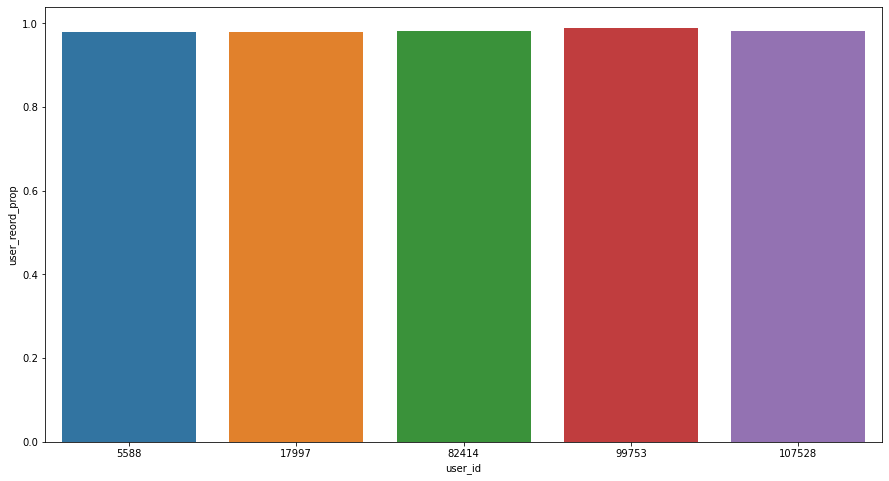

In [14]:
plt.figure(figsize=(15,8))
sns.barplot(x="user_id", y="user_reord_prop", data=user_reord_prop.head(5))
plt.show()

From the above plot we can understand that user 99753 reorders more often than not followed by user 82414 and so on.

# Products

# Plotting PDF of Product_id

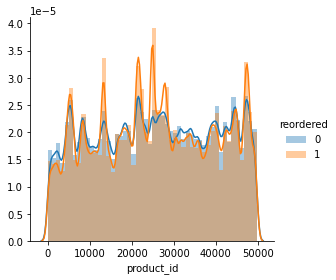

In [17]:
sns.FacetGrid(user_order_products_all_details,hue='reordered',height=4)\
.map(sns.distplot,'product_id')\
.add_legend()
plt.show()

From the above graph, we can observe that some of the products are more ofter reordered than not when compared to other products

In [87]:
#loading the pre-computed product_reord_prop, the proportion of reorders of a product out of all its purchases
product_reord_prop=product_features[['product_id','product_name','product_reord_prop']]
product_reord_prop.sort_values(['product_reord_prop'],ascending=False,inplace=True)
top_products=product_reord_prop.head(10).product_id.values
product_reord_prop.head(10)

,product_id,product_name,product_reord_prop
6430,6433,Raw Veggie Wrappers,0.941176
2074,2075,Serenity Ultimate Extrema Overnight Pads,0.931034
43545,43553,Orange Energy Shots,0.923077
27734,27740,Chocolate Love Bar,0.920792
14605,14609,Soy Powder Infant Formula,0.914286
13871,13875,Simply Sleep Nighttime Sleep Aid,0.911111
39984,39992,"Energy Shot, Grape Flavor",0.909091
5865,5868,Russian River Valley Reserve Pinot Noir,0.900000
31412,31418,Sparking Water,0.900000
35598,35604,Maca Buttercups,0.900000


# Plotting barplot of product_reord_prop

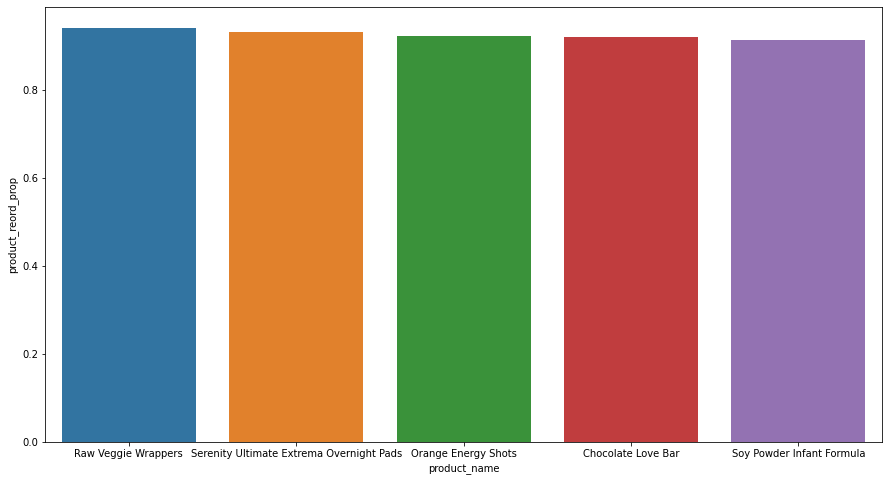

In [35]:
plt.figure(figsize=(15,8))
sns.barplot(x="product_name", y="product_reord_prop", data=product_reord_prop.head(5))
plt.show()

From the above plot we can observe that 'Raw Veggie Wrappers' are more often reordered than not when compared to 'Serenity Ultimate Extrema Overnight pads' and so on.

# days_since_prior_order

# Plotting PDF of days_since_prior_order

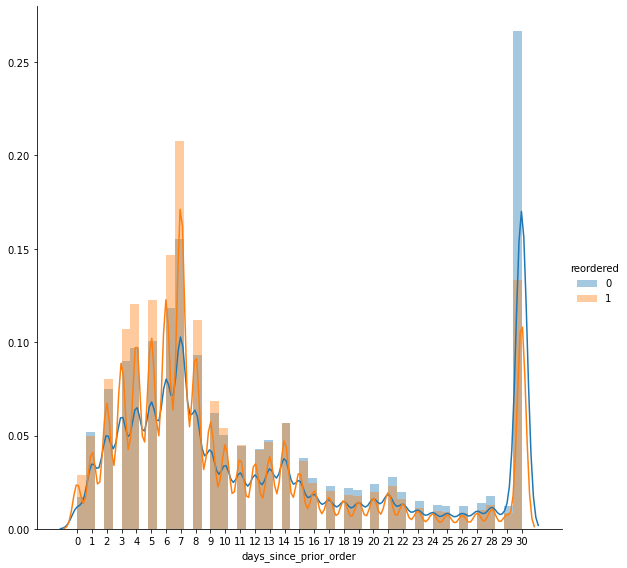

In [35]:
sns.FacetGrid(user_order_products_all_details,hue='reordered',height=8)\
.map(sns.distplot,'days_since_prior_order')\
.set(xticks=range(0,31))\
.add_legend()
plt.show()

We can observe from the above plot that the number of reordered products are higher when days since prior order is short and the peak difference occuring at 7 days,as the number of days since prior increases, the number of reorders seems to fall much short.We can also observe that number of reorders are higher at 7 days and 30 days there by showing us the trend that users try to buy certain products weekly and monthly.


# Plotting Boxplot of days_since_prior_order

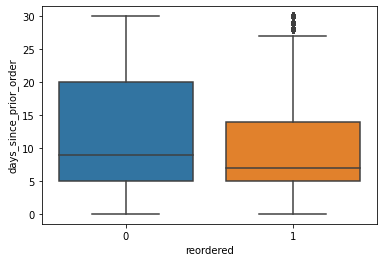

In [36]:
sns.boxplot(x='reordered',y='days_since_prior_order',data=user_order_products_all_details)
plt.show()

From the above plot we can observe that days since prior order is less for reordered products than for non reorders.Hence a good threshold for days_since_prior_order can partly solve our classification problem

# Order_dow

# Plotting PDF of Order dow

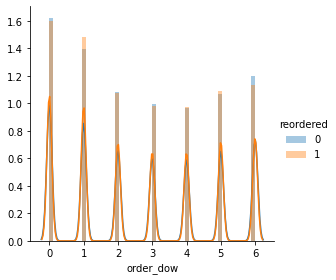

In [19]:
sns.FacetGrid(user_order_products_all_details,hue='reordered',height=4)\
.map(sns.distplot,'order_dow')\
.add_legend()
plt.show()

From the above plot, we can see that there is no significant difference between the distribution of reorders and non reorders over days of the week

# Plotting Boxplot of order_dow

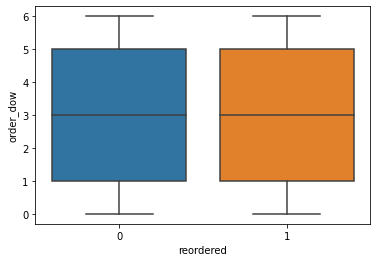

In [37]:
sns.boxplot(x='reordered',y='order_dow',data=user_order_products_all_details)
plt.show()

This plot confirms that theday of the week alone does not seem to contribute much to number of reordered products. 

In [48]:
#loading pre-computed order_dow_reordered_prop, the proportion of total purchases on each day of the week the user has reordered
order_dow_features=pd.read_csv('order_dow_features.csv')
order_dow_features.sort_values(['order_dow_reordered_prop'],ascending=False,inplace=True)
order_dow_features

,order_dow,order_dow_reordered,order_dow_reordered_prop
1,1,3421285,0.603843
5,5,2506649,0.595470
4,4,2238166,0.590979
2,2,2487537,0.589771
3,3,2253698,0.586272
0,0,3634366,0.585276
6,6,2584835,0.574369


# Plotting barplot of order_dow_reordered_prop

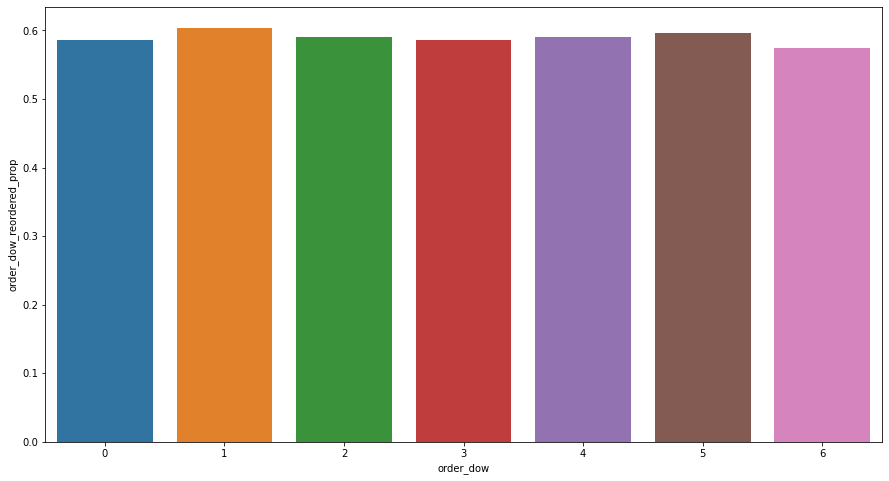

In [46]:
plt.figure(figsize=(15,8))
sns.barplot(x="order_dow", y="order_dow_reordered_prop", data=order_dow_features)
plt.show()

From the above plot, we can observe that the probability of reordering is more on 1st day of the week followed by 5th day of the week and so on.

# Order_hour_of_day 

# Plotting PDF of order_hour_of_day

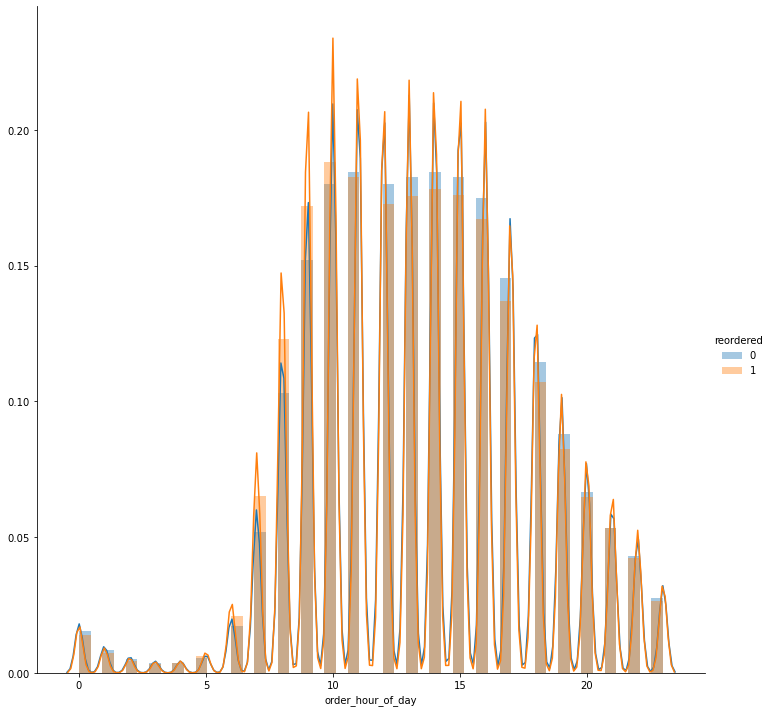

In [31]:
sns.FacetGrid(user_order_products_all_details,hue='reordered',height=10)\
.map(sns.distplot,'order_hour_of_day')\
.add_legend()
plt.show()

The number of reorders seems to dominate during 6-9 hours of the day and seems to fall short compared to non-reordered products during 11-19 hr. There is no such dominance during the remaining hours.

# Plotting Boxplot of Order_hour_of_day

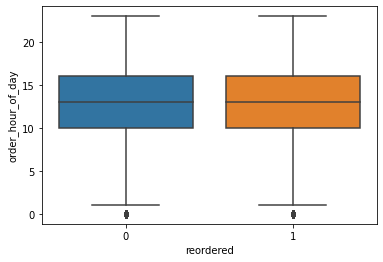

In [38]:
sns.boxplot(x='reordered',y='order_hour_of_day',data=user_order_products_all_details)
plt.show()

From this plot we cannot make a difference between our classes by taking order_hour_of_day feature alone

In [49]:
#loading pre-computed order_hod_reordered_prop, the proportion of total purchases on each hour of the day, the user has reordered
order_hod_features=pd.read_csv('order_hod_features.csv')
order_hod_features.sort_values(['order_hod_reordered_prop'],ascending=False,inplace=True)
order_hod_features.head(5)

,order_hour_of_day,order_hod_reordered,order_hod_reordered_prop
7,7,574829,0.644473
6,6,185090,0.636497
8,8,1086821,0.631883
9,9,1521808,0.619449
5,5,53537,0.607947


# Plotting bar-plot of order_hod_reordered_prop

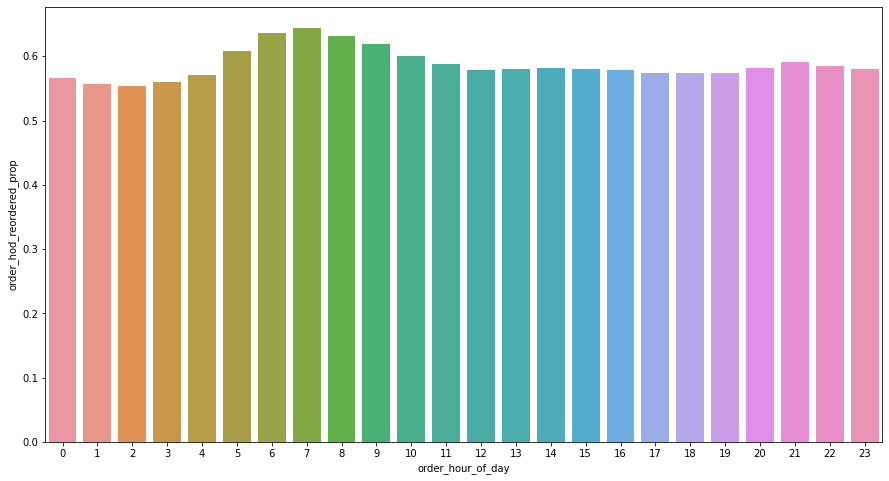

In [50]:
plt.figure(figsize=(15,8))
sns.barplot(x="order_hour_of_day", y="order_hod_reordered_prop", data=order_hod_features)
plt.show()

From the above plot, we can observe that the probability of reordering is more on 7th hour of the day followed by 6th hour of the day and so on.We can colude that user reordering patterns lie in early morning hours 6-8

# Order Number

# Plotting PDF of Order Number

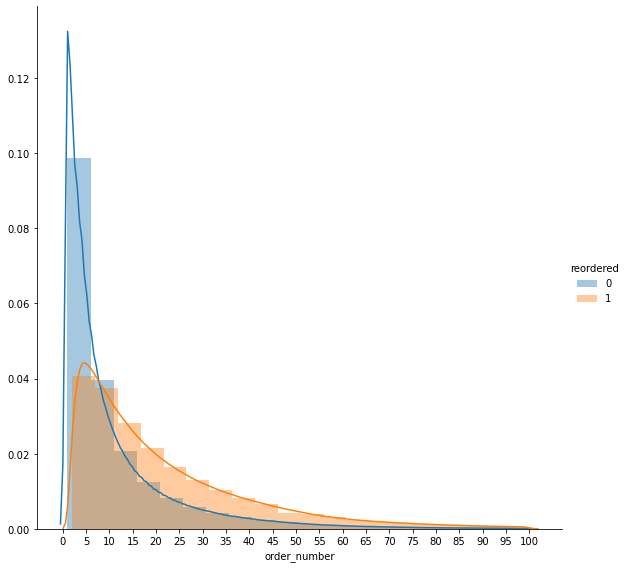

In [49]:
sns.FacetGrid(user_order_products_all_details,hue='reordered',height=8)\
.map(sns.distplot,'order_number',bins=20)\
.set(xticks=range(0,101,5))\
.add_legend()
plt.show()

From the above plot, we can observe that when the order number is less than 10 the non-reordered class dominates and when order number is greater than 10, the reordered class starts to dominate

# Plotting Boxplot of Order number

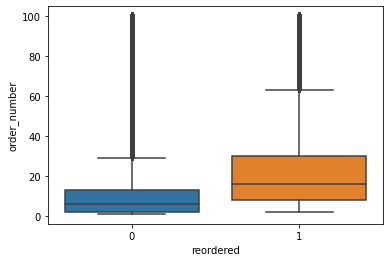

In [50]:
sns.boxplot(x='reordered',y='order_number',data=user_order_products_all_details)
plt.show()

This plot backs the previous observation, a threshold around 10 of order number can do a decent job in differentiating the classes

# Aisle_id

In [21]:
#loading pre_computed aisle_reordered_prop, the proportion of reorders for each aisle out of all its purchases
aisle_features=pd.read_csv('aisle_features.csv')
aisles=pd.read_csv('aisles.csv')
aisle_features=pd.merge(aisle_features,aisles,on='aisle_id',how='left')
aisle_features.sort_values(['aisle_reordered_prop'],ascending=False,inplace=True)
aisle_features.head(5)


,aisle_id,aisle_reordered,aisle_reordered_prop,aisle
83,84,696264,0.781428,milk
114,115,613977,0.729593,water seltzer sparkling water
23,24,2615469,0.718104,fresh fruits
85,86,318920,0.705366,eggs
90,91,442023,0.692551,soy lactosefree


# Plotting boxplot of aisle_reordered_prop

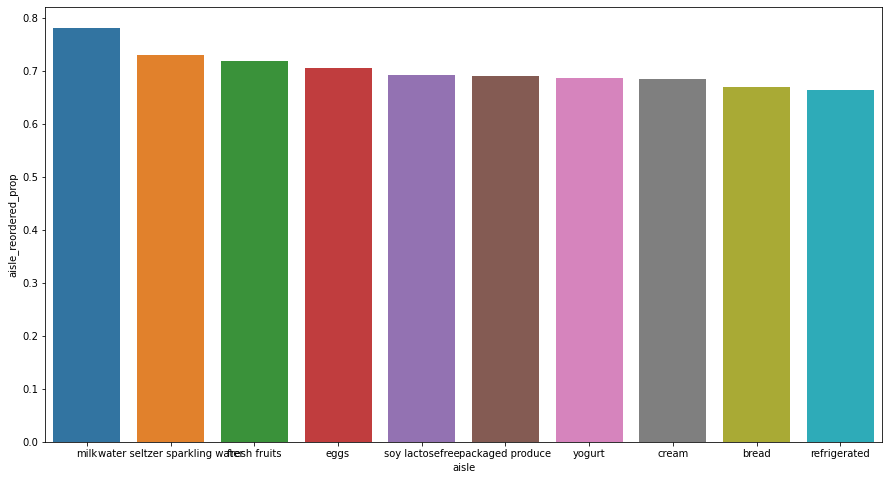

In [25]:
plt.figure(figsize=(15,8))
sns.barplot(x="aisle", y="aisle_reordered_prop", data=aisle_features.head(10))
plt.show()

From the above plot, we can observe that milk is the most reordered aisle followed by seltzer sparkling water followed by fresh fruits, eggs and so on

# Department_id

In [27]:
#loading pre-computed dep_reordered_prop, the proportion of reorders of a department out of all its purchases
dep_features=pd.read_csv('dep_features.csv')
departments=pd.read_csv('departments.csv')
dep_features=pd.merge(dep_features,departments,on='department_id',how='left')
dep_features.sort_values(['dep_reordered_prop'],ascending=False,inplace=True)
dep_features.head()

,department_id,dep_reordered,dep_reordered_prop,department
15,16,3627221,0.669969,dairy eggs
6,7,1757892,0.653460,beverages
3,4,6160710,0.649913,produce
2,3,739188,0.628141,bakery
19,20,638864,0.607719,deli


# Plotting Barplot of dep_reordered_prop

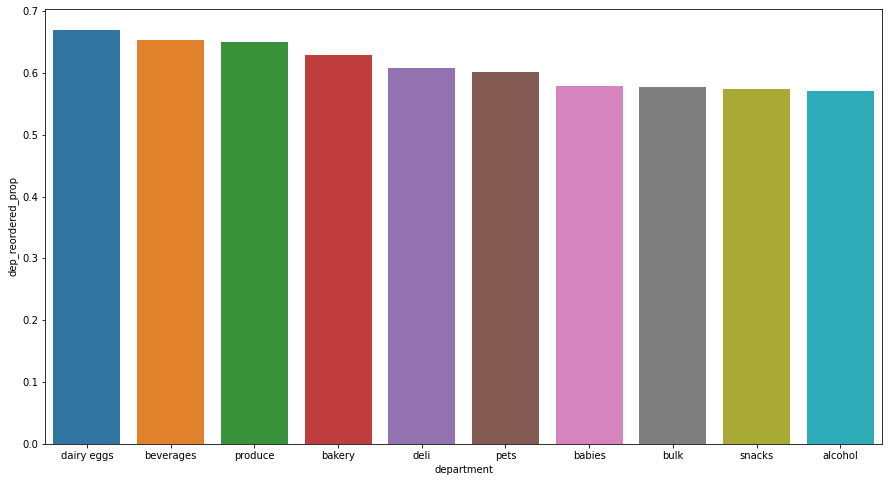

In [28]:
plt.figure(figsize=(15,8))
sns.barplot(x="department", y="dep_reordered_prop", data=dep_features.head(10))
plt.show()

From the above plot, we can observe that dairy eggs is the most reordered product followed by beverages,produce, bakery and so on

# Add_to_Cart_Order

# Plotting PDF of add_to_cart_order

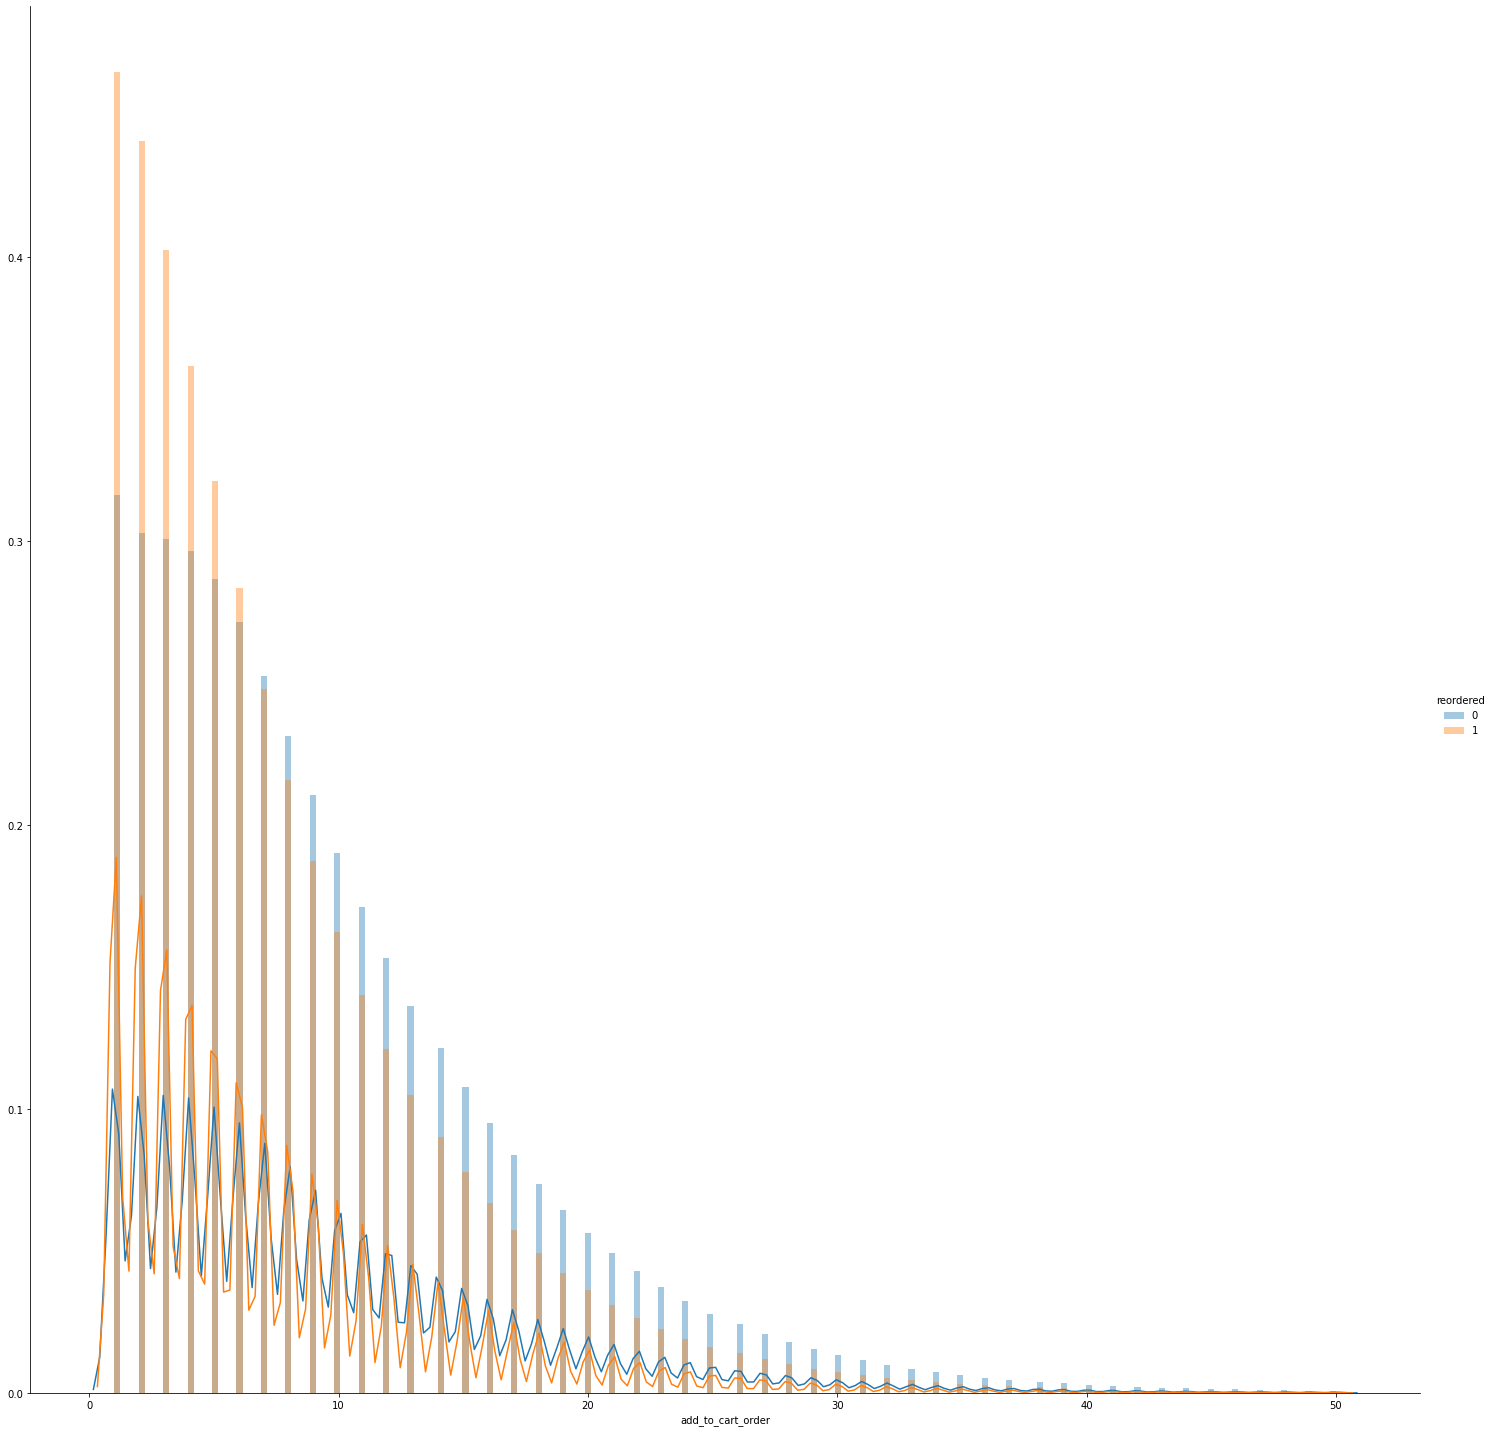

In [18]:
#plotting PDF of first 50 add_to_cart_order for better view
sns.FacetGrid(user_order_products_all_details[user_order_products_all_details.add_to_cart_order<=50],hue='reordered',height=20)\
.map(sns.distplot,'add_to_cart_order',bins=200)\
.add_legend()
plt.show()

From the above plot we can observe that when add_to_cart_order is less than or equal to 5 , the number of reorders dominate while after 5, the number of non-reorders dominate

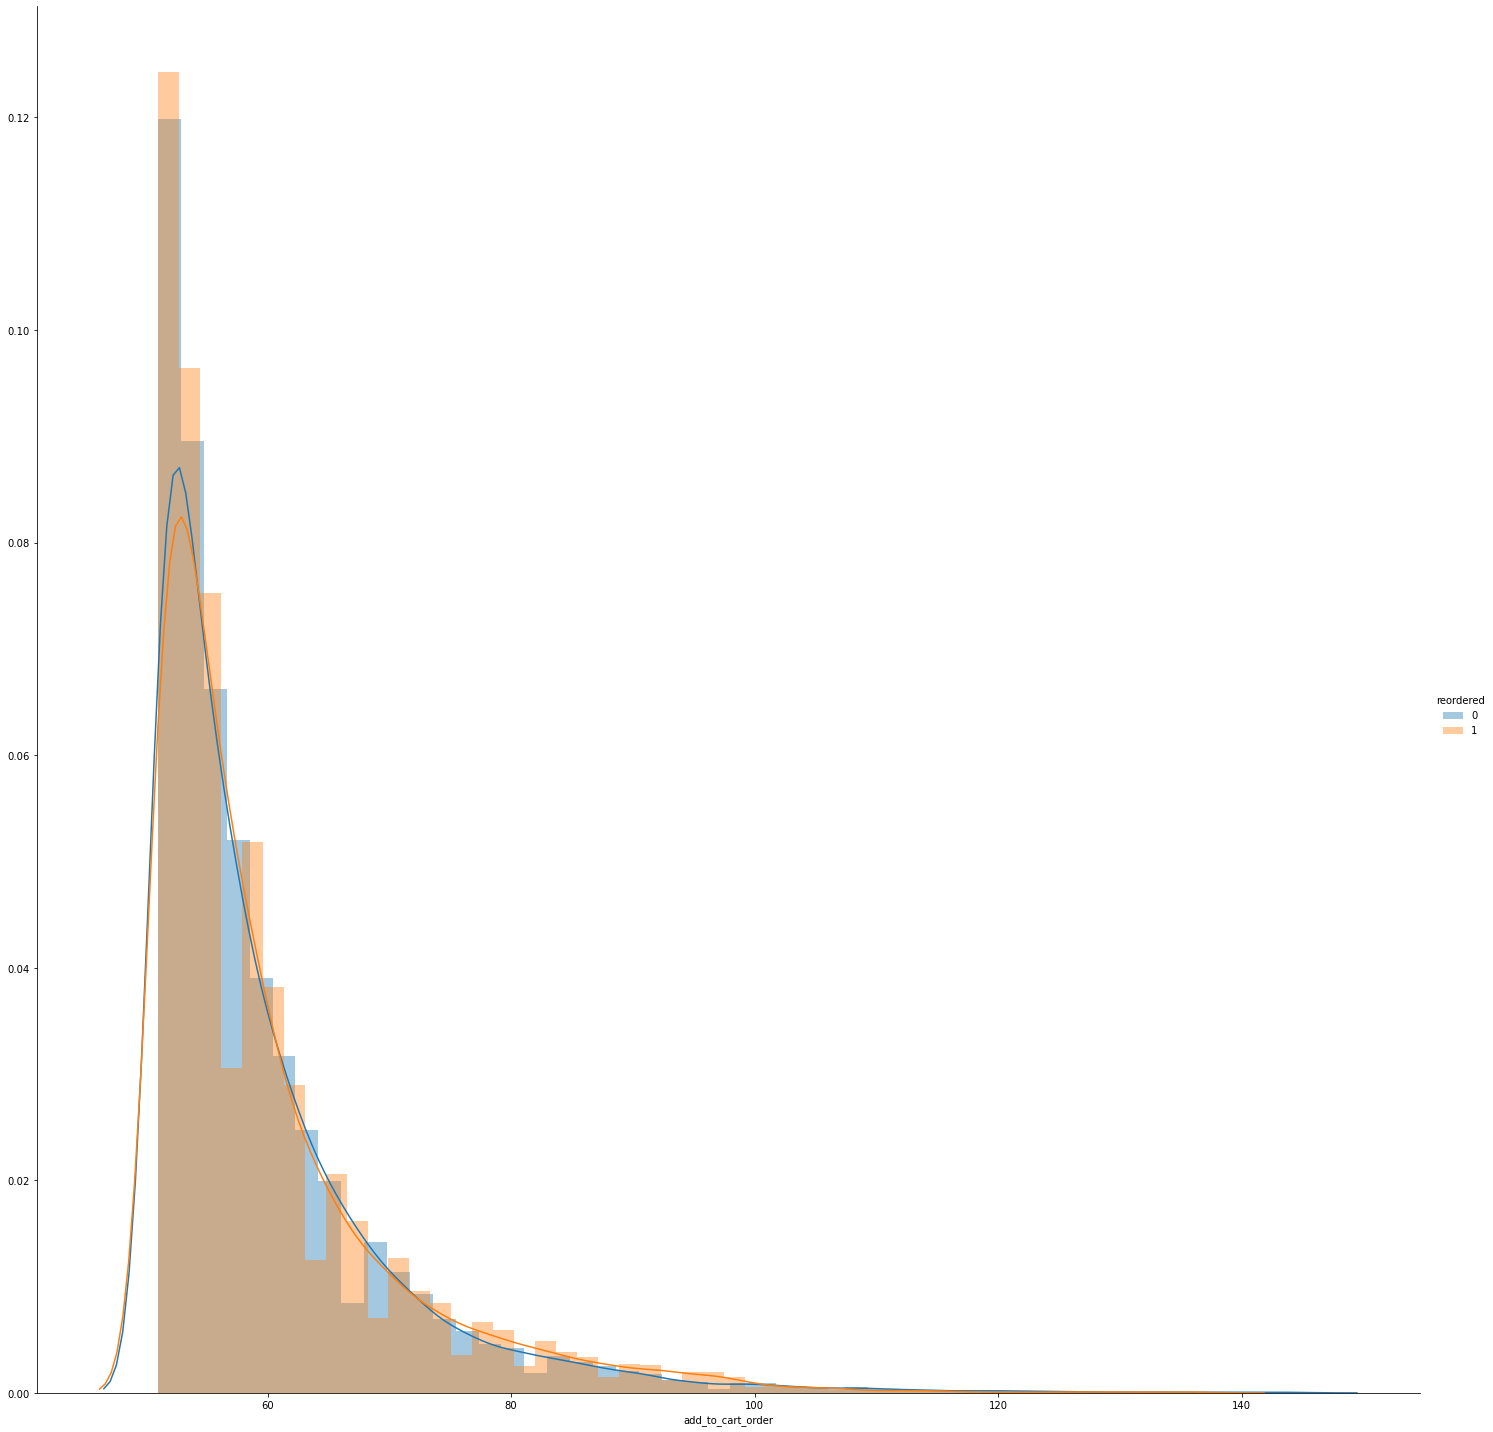

In [62]:
#plotting pdf when add_to_cart_order>50
sns.FacetGrid(user_order_products_all_details[user_order_products_all_details.add_to_cart_order>50],hue='reordered',height=20)\
.map(sns.distplot,'add_to_cart_order')\
.add_legend()
plt.show()

From this plot we can observe that there is an alternative pattern between the classes as add_to_cart_order increases

# Plotting Boxplot of add_to_cart_order

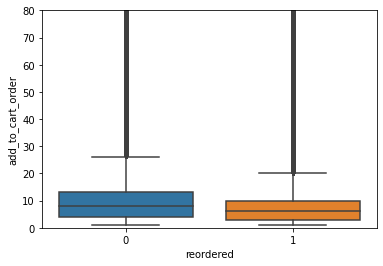

In [70]:
sns.boxplot(x='reordered',y='add_to_cart_order',data=user_order_products_all_details).set(ylim=(0,80))
plt.show()

This plot confirms the observation, during 0-5 we can see that reordered class dominates and post 10, non-reorders completely dominates

# Multi-Variate Analysis

# Order_dow and Order_hour_of_day

In [15]:
#loading pre-computed order_dow_hod_reord_prop, the proportion of total purchases on a particular day of the week and particular hour of the day, users has reordered
order_dow_hod_features=pd.read_csv('order_dow_hod_features.csv')
order_dow_hod_features.sort_values(['order_dow_hod_reord_prop'],ascending=False,inplace=True)
order_dow_hod_features.head(5)

,order_dow,order_hour_of_day,order_dow_hod_reord_count,order_dow_hod_reord_prop
31,1,7,111106,0.671571
32,1,8,220660,0.661973
30,1,6,34784,0.659062
33,1,9,329573,0.651143
79,3,7,71148,0.642687


# Plotting heatmap illustrating reordering probability in order_dow, order_hour_of_day space

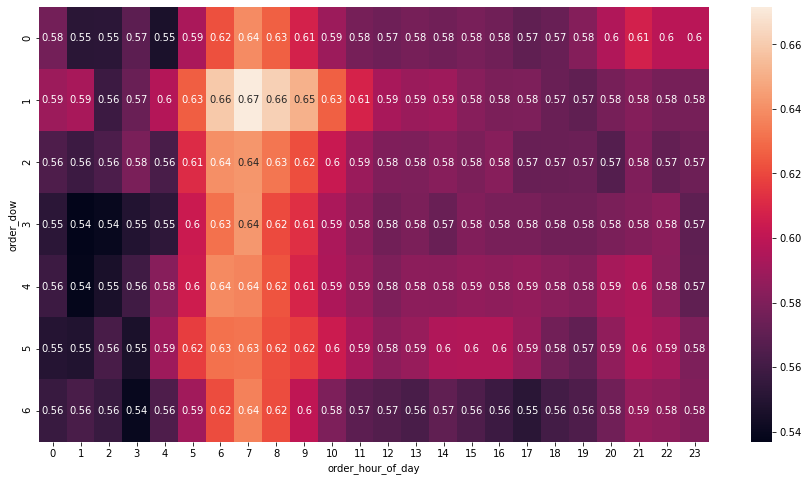

In [64]:
plt.figure(figsize=(15,8))
sns.heatmap(order_dow_hod_features.pivot('order_dow','order_hour_of_day','order_dow_hod_reord_prop'),annot=True)
plt.show()

From the above plot, we can observe that probability of reordering is more on 1st dow 7th hod,followed by 1st dow 8th hod and so on.

# User Product count

In [35]:
#loading pre-computed user_product_cnt, the count of number of times a user has ordered a product
user_product_cnt=pd.read_csv('user_product_cnt.csv')
user_product_cnt=pd.merge(user_product_cnt,products[['product_id','product_name']],on='product_id',how='left')
user_product_cnt.sort_values(['user_id','user_product_cnt'],ascending=False,inplace=True)
user_product_cnt.head(10)

,user_id,product_id,user_product_cnt,product_name
13307897,206209,6846,10,Diet Pepsi Pack
13307899,206209,9405,9,Calcium Enriched 100% Lactose Free Fat Free Milk
13307946,206209,41213,7,French Loaf
13307903,206209,13176,6,Bag of Organic Bananas
13307913,206209,19348,4,Fat Free Milk
13307921,206209,23594,4,Medium Salsa
13307925,206209,24852,4,Banana
13307939,206209,38167,4,Ultra Downy® Clean Breeze™ Liquid Fabric Condi...
13307909,206209,15700,3,Cheddar Cheese Nut Thins Cracker Snacks
13307923,206209,23892,3,Original High Efficiency Liquid Laundry Detergent


From the above table, we can understand that a user reorders some of their products more often than the other products. In the above table we can observe that user 206209 has reordered 'Diet Pepsi pack' followed by 'Calcium Enriched 100% Lactose Free Fat Free Milk', 'French loaf'  more than he/she reorders any other product.

# Conclusion

We performed EDA on several different reordered count with different features. We found that some of the features contribute to the classification problem.
Some of them were found to be not contributing alone to the classification problem, they might contribute in combination with other features. Following this we will extract more number of features based on reordered counts